##### test for select_models function
- maybe use the introduction model from figure 1
- 3 models with 2, 5, 15 steps respectively
- create some data with 5-steps model
- is this fast/handy enough for a test?
- run in sequential mode/not parallel

=> test seems to work but is a bit expensive, maybe add later

In [1]:
import memo_py as me
import numpy as np

/Users/mlanghinrichs/Documents/Studium/MSc/09_hiwi_hoefer/01_project/memo_py/memo_py/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
### create data from 5-steps model
t = [
    {'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 'reaction_steps': 5}
    ]

net = me.Network('net_div_g5')
net.structure(t)

num_iter = 1000
initial_values = {'X_t': 1}
theta_values = {'l': 0.22}
time_values = np.array([0.0, 10.0])
variables = {'X_t': ('X_t', )}

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

sims = np.array(res_list)

In [3]:
data = me.Data('data_test_select_models')
data.load(['X_t',], time_values, sims, bootstrap_samples=10000, basic_sigma=1/num_iter)

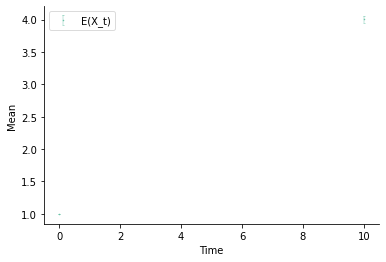

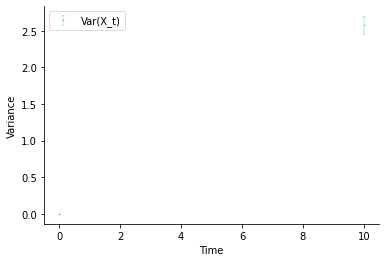

In [4]:
me.plots.data_mean_plot(data)
me.plots.data_variance_plot(data)

In [5]:
t2 = [{'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 
     'reaction_steps': 2}]

t5 = [{'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 
     'reaction_steps': 5}]

t15 = [{'start': 'X_t', 'end': 'X_t', 
     'rate_symbol': 'l', 
     'type': 'S -> S + S', 
     'reaction_steps': 15}]

s = {'initial_values': {'X_t': 1.0}, 
     'theta_bounds': {'l': (0.0, 1.0)}, 
     'variables': {'X_t': ('X_t', )}}

models = [('m2', t2, s), ('m5', t5, s), ('m15', t15, s)]
print(len(models))
print(models)

3
[('m2', [{'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 2}], {'initial_values': {'X_t': 1.0}, 'theta_bounds': {'l': (0.0, 1.0)}, 'variables': {'X_t': ('X_t',)}}), ('m5', [{'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 5}], {'initial_values': {'X_t': 1.0}, 'theta_bounds': {'l': (0.0, 1.0)}, 'variables': {'X_t': ('X_t',)}}), ('m15', [{'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 15}], {'initial_values': {'X_t': 1.0}, 'theta_bounds': {'l': (0.0, 1.0)}, 'variables': {'X_t': ('X_t',)}})]


In [6]:
est_res = me.selection.select_models(models, data, parallel=False)

/Users/mlanghinrichs/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


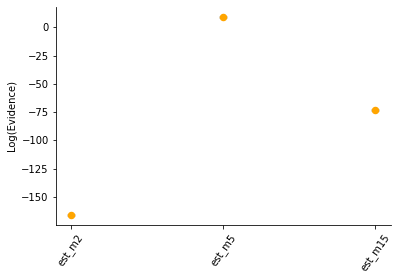

In [7]:
me.plots.selection_plot(est_res)

In [8]:
me.selection.compute_model_probabilities(est_res)

array([1.22197837e-76, 1.00000000e+00, 1.78172736e-36])

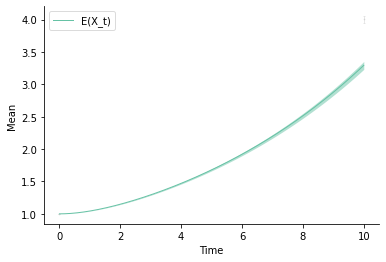

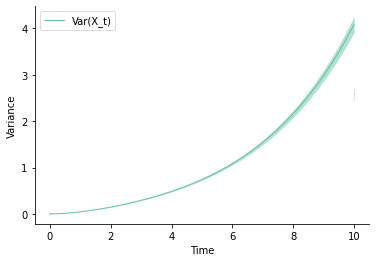

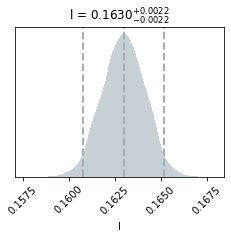

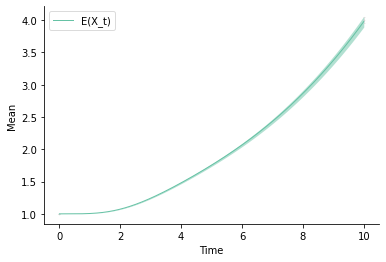

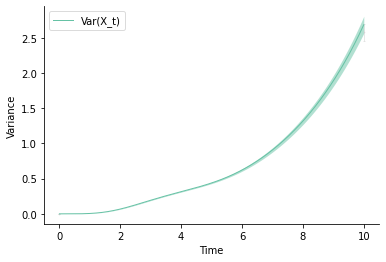

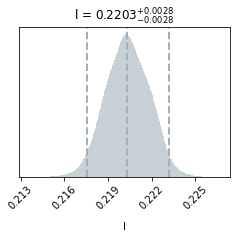

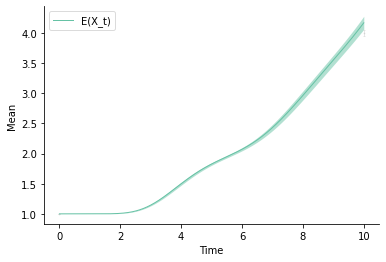

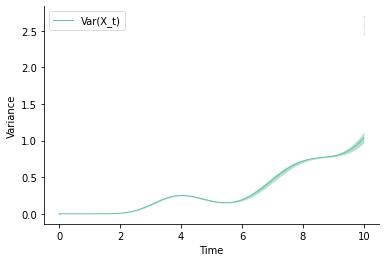

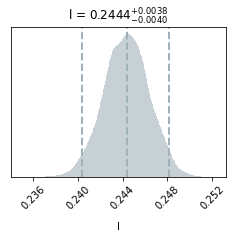

In [12]:
me.plots.est_bestfit_mean_plot(est_res[0])
me.plots.est_bestfit_variance_plot(est_res[0])
me.plots.est_corner_kernel_plot(est_res[0])

me.plots.est_bestfit_mean_plot(est_res[1])
me.plots.est_bestfit_variance_plot(est_res[1])
me.plots.est_corner_kernel_plot(est_res[1])

me.plots.est_bestfit_mean_plot(est_res[2])
me.plots.est_bestfit_variance_plot(est_res[2])
me.plots.est_corner_kernel_plot(est_res[2])